In [1]:
#import all relevant packages

import pandas as pd
import os
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import KMeansSMOTE
from google.colab import files

In [4]:
#import the data file, method depending on GUI

#os.chdir("/clean_BNPL_clients.csv")

#files.upload()
bnpl = pd.read_csv('clean_BNPL_python.csv')

In [5]:
#review imported file to check its correct

display(bnpl.shape)
bnpl.head()

(59053, 29)

,Unnamed: 0,loan_amnt,loan_term,int_rate,monthly_payment,sub_grade,emp_length,home_ownership,annual_inc,verification_status,...,mort_acc,num_accts_120_pd,pub_rec_bankruptcies,tax_liens,credit_limit,total_bal_ex_mort,hardship_flag,disbursement_method,debt_settlement_flag,loan_status
0,0,2500,36 months,13.56,84.92,C1,10+ years,RENT,55000.0,Not Verified,...,0,0,1,0,60124,16901,N,Cash,N,solvent
1,6,2000,36 months,17.97,72.28,D1,4 years,RENT,51000.0,Source Verified,...,0,0,0,0,854,854,N,Cash,N,solvent
2,15,3500,36 months,16.14,123.30,C4,10+ years,MORTGAGE,80000.0,Verified,...,2,7,0,0,42328,16085,N,Cash,N,solvent
3,23,3500,36 months,20.89,131.67,D4,10+ years,MORTGAGE,40000.0,Source Verified,...,4,2,0,0,217000,26902,N,Cash,N,solvent
4,33,3300,36 months,23.40,128.44,E1,3 years,RENT,49700.0,Source Verified,...,0,3,0,0,170985,166884,N,Cash,N,solvent


In [6]:
#define a function to convert category features into numerical, to be used for SMOTE Resampling

def encode_categoricals(df, categorical_features):
  for col in categorical_features:
    df[col] = df[col].astype("category")
  return df

The data is in no particular order, such as alphabetical or ascending in order of loan amount, so there is no need to randomly shuffle the rows.

In [ ]:
#check the distribution of target variable

bnpl['loan_status'].value_counts(normalize=False)

,count
loan_status,
solvent,54366
default,4687


There is clean imbalance between the target variable categories. SMOTE Resampling will be used to assist the models in their prediction.

The BNPL dataset contains both numerical and categorical data, thus we'll convert the categorical variables to numerical.

In [7]:
#identify the numerical categories

bnpl_continuous = bnpl[['loan_amnt', 'int_rate', 'monthly_payment', 'annual_inc', 'total_dti', 'tot_coll_amt', 'tot_cur_bal', \
                                  'total_bal_ex_mort','credit_limit']]

#identify categorical categories

bnpl_categor = bnpl[['loan_term', 'sub_grade', 'emp_length', 'home_ownership', 'verification_status', 'loan_purpose', \
                               'delinq_2yrs', 'open_acc','addr_state', 'application_type', 'cur_acct_delinq', 'mort_acc', \
                               'num_accts_120_pd', 'pub_rec_bankruptcies', 'tax_liens', 'hardship_flag', 'disbursement_method', \
                               'debt_settlement_flag']]
#source the column indices
bnpl_categor_indx = [bnpl.columns.get_loc(col) for col in bnpl_categor]

In [8]:
#use the encoding function to convert the string variables into numerical

bnpl_num = encode_categoricals(bnpl, bnpl_categor)

#enact one-hot encoding
bnpl_num = pd.get_dummies(bnpl_num, columns=bnpl_categor.columns,
                          prefix = bnpl_categor.columns)
display(bnpl_num.info())
display(bnpl_num.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59053 entries, 0 to 59052
Columns: 279 entries, Unnamed: 0 to debt_settlement_flag_Y
dtypes: bool(268), float64(4), int64(6), object(1)
memory usage: 20.0+ MB


None

,Unnamed: 0,loan_amnt,int_rate,monthly_payment,annual_inc,total_dti,tot_coll_amt,tot_cur_bal,credit_limit,total_bal_ex_mort,...,tax_liens_6,tax_liens_7,tax_liens_8,tax_liens_9,hardship_flag_N,hardship_flag_Y,disbursement_method_Cash,disbursement_method_DirectPay,debt_settlement_flag_N,debt_settlement_flag_Y
0,0,2500,13.56,84.92,55000.0,18.24,0,16901,60124,16901,...,False,False,False,False,True,False,True,False,True,False
1,6,2000,17.97,72.28,51000.0,2.40,0,854,854,854,...,False,False,False,False,True,False,True,False,True,False
2,15,3500,16.14,123.30,80000.0,13.63,0,16085,42328,16085,...,False,False,False,False,True,False,True,False,True,False
3,23,3500,20.89,131.67,40000.0,9.09,0,189794,217000,26902,...,False,False,False,False,True,False,True,False,True,False
4,33,3300,23.40,128.44,49700.0,14.32,0,166884,170985,166884,...,False,False,False,False,True,False,True,False,True,False


In [9]:
#split the data into training and test sets

bnpl_att = bnpl_num.drop(['loan_status'], axis=1)
bnpl_tar = bnpl_num['loan_status']

from sklearn.model_selection import train_test_split

bnpl_att_train, bnpl_att_test, bnpl_tar_train, bnpl_tar_test = train_test_split(bnpl_att, bnpl_tar, test_size=0.3, random_state=55)

In [10]:
#resample the data with SMOTE, which will go on to be used in the models

from imblearn.over_sampling import SMOTE
bnpl_smote = SMOTE(random_state=1000)

bnpl_train_att_resample, bnpl_train_tar_resample = bnpl_smote.fit_resample(bnpl_att_train, bnpl_tar_train)

a simple view via .shape tells us the _resample variables have increased in size compared to their origins

In [11]:
print(bnpl_train_att_resample.shape)
print(bnpl_train_tar_resample.shape)

(76076, 278)
(76076,)


In [12]:
bnpl_train_att_resample.columns

Index(['Unnamed: 0', 'loan_amnt', 'int_rate', 'monthly_payment', 'annual_inc',
       'total_dti', 'tot_coll_amt', 'tot_cur_bal', 'credit_limit',
       'total_bal_ex_mort',
       ...
       'tax_liens_6', 'tax_liens_7', 'tax_liens_8', 'tax_liens_9',
       'hardship_flag_N', 'hardship_flag_Y', 'disbursement_method_Cash',
       'disbursement_method_DirectPay', 'debt_settlement_flag_N',
       'debt_settlement_flag_Y'],
      dtype='object', length=278)

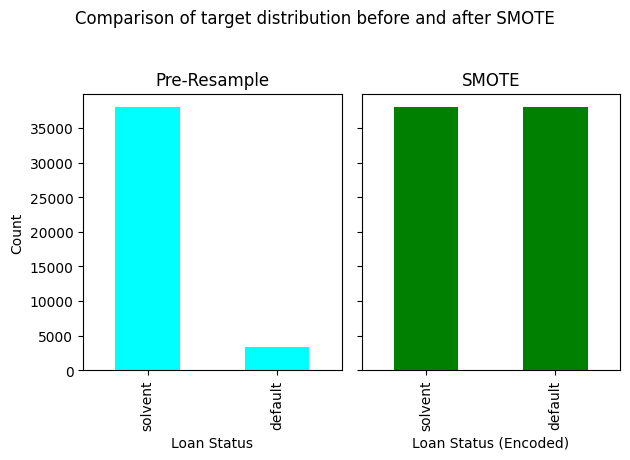

In [15]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
fig.suptitle('Comparison of target distribution before and after SMOTE')

# Plot pre-resample target distribution on ax1
bnpl_tar_train.value_counts().plot(kind="bar", color="cyan", ax=ax1)
ax1.set_title("Pre-Resample")
ax1.set_xlabel('Loan Status')
ax1.set_ylabel('Count')

# Plot post-resample target distribution on ax2
bnpl_train_tar_resample.value_counts().plot(kind='bar', color="green", ax=ax2)
ax2.set_title("SMOTE")
ax2.set_xlabel('Loan Status (Encoded)')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to leave space for subtitle
plt.show()

## We will now go on to resample with kMeansSMOTE to see if there are differing results (accuracy, ROC Curve) with two means of resampling.

In [16]:
#resample the data with k-means SMOTE methods

from imblearn.over_sampling import KMeansSMOTE
bnpl_KMsmote = KMeansSMOTE(random_state=1000, cluster_balance_threshold=0.1, kmeans_estimator=30)

bnpl_train_att_KM_resample, bnpl_train_tar_KM_resample = bnpl_KMsmote.fit_resample(bnpl_att_train, bnpl_tar_train)

In [17]:
print(bnpl_train_att_KM_resample.shape)
print(bnpl_train_tar_KM_resample.shape)

(76085, 278)
(76085,)


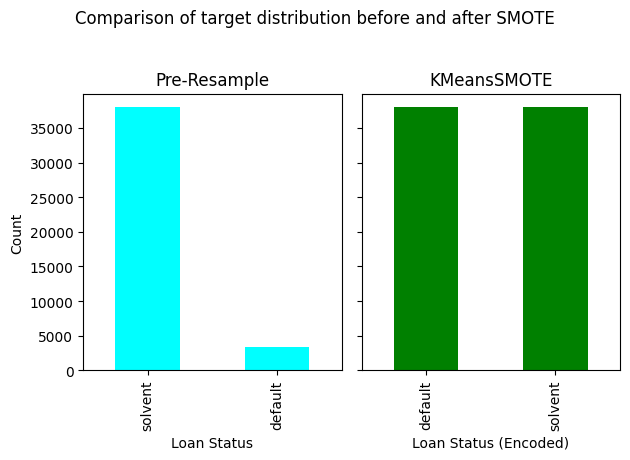

In [18]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
fig.suptitle('Comparison of target distribution before and after SMOTE')

# Plot pre-resample target distribution on ax1
bnpl_tar_train.value_counts().plot(kind="bar", color="cyan", ax=ax1)
ax1.set_title("Pre-Resample")
ax1.set_xlabel('Loan Status')
ax1.set_ylabel('Count')

# Plot post-resample target distribution on ax2
bnpl_train_tar_KM_resample.value_counts().plot(kind='bar', color="green", ax=ax2)
ax2.set_title("KMeansSMOTE")
ax2.set_xlabel('Loan Status (Encoded)')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to leave space for suptitle
plt.show()


# With the data resampling taken care of, we can move onto the model development.